# Multimodal Cyclic Translation Network (MCTN) Model - MOSI

In this notebook, we implement the MCTN Model, and test it on CMU-MOSI dataset.

## Importing Libraries

In [1]:
import os
import sys
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

## Importing Helper Functions

In [2]:
from helpers.data.get_data import get_dataloader
from helpers.unimodals.common_models import GRU, MLP
from helpers.fusions.MCTN import Encoder, Decoder
from helpers.training.all_in_one import all_in_one_train
from helpers.training.MCTN import train, test
from helpers.utils.common_utils import get_default_device, save_results, format_time

## Loading the Dataset

In [3]:
traindata, validdata, testdata = get_dataloader('/scratch/rrm9598/data/mosi_raw.pkl', robust_test=False)

In [4]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [5]:
max_seq = 20
feature_dim = 300
hidden_dim = 32

encoder0 = Encoder(feature_dim, hidden_dim, n_layers=1, dropout=0.0).to(device)
decoder0 = Decoder(hidden_dim, feature_dim, n_layers=1, dropout=0.0).to(device)
encoder1 = Encoder(hidden_dim, hidden_dim, n_layers=1, dropout=0.0).to(device)
decoder1 = Decoder(hidden_dim, feature_dim, n_layers=1, dropout=0.0).to(device)

reg_encoder = nn.GRU(hidden_dim, 32).to(device)
head = MLP(32, 64, 1).to(device)

allmodules = [encoder0, decoder0, encoder1, decoder1, reg_encoder, head]

## Training

In [6]:
FILE_NAME = 'mosi_mctn_r0'

In [7]:
def trainprocess():
    global FILE_NAME
    
    train_losses, valid_losses = train(
        traindata, validdata,
        encoder0, decoder0, encoder1, decoder1,
        reg_encoder, head,
        criterion_t0=nn.MSELoss(), criterion_c=nn.MSELoss(),
        criterion_t1=nn.MSELoss(), criterion_r=nn.L1Loss(),
        max_seq_len=20,
        mu_t0=0.01, mu_c=0.01, mu_t1=0.01,
        dropout_p=0.15, early_stop=False, patience_num=15,
        lr=1e-4, weight_decay=0.01, op_type=torch.optim.AdamW,
        epoch=200, model_save=f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt')
    return train_losses, valid_losses

In [8]:
train_losses, valid_losses = all_in_one_train(trainprocess, allmodules)

Epoch [1/200]
Train Loss: 3.0502 | Regression Loss: 1.3307 | Embedding Loss: 1.7195
Valid MAE: 1.4147 | Valid Accuracy: 57.4766% | Valid Recall: 61.1940%
Saving Best

Epoch [2/200]
Train Loss: 3.0359 | Regression Loss: 1.3202 | Embedding Loss: 1.7156
Valid MAE: 1.4157 | Valid Accuracy: 57.4766% | Valid Recall: 61.1940%

Epoch [3/200]
Train Loss: 3.0482 | Regression Loss: 1.3332 | Embedding Loss: 1.7149
Valid MAE: 1.4135 | Valid Accuracy: 57.4766% | Valid Recall: 61.1940%
Saving Best

Epoch [4/200]
Train Loss: 3.0388 | Regression Loss: 1.3224 | Embedding Loss: 1.7164
Valid MAE: 1.4106 | Valid Accuracy: 57.4766% | Valid Recall: 61.1940%
Saving Best

Epoch [5/200]
Train Loss: 3.0611 | Regression Loss: 1.3419 | Embedding Loss: 1.7191
Valid MAE: 1.4133 | Valid Accuracy: 57.4766% | Valid Recall: 61.1940%

Epoch [6/200]
Train Loss: 3.0438 | Regression Loss: 1.3227 | Embedding Loss: 1.7212
Valid MAE: 1.4137 | Valid Accuracy: 57.4766% | Valid Recall: 61.1940%

Epoch [7/200]
Train Loss: 3.0277 |

Text(0.5, 1.0, 'Loss vs. No. of epochs')

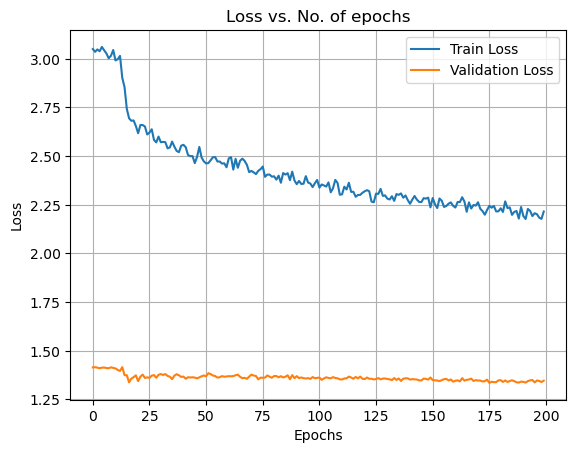

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [10]:
save_results(train_losses, valid_losses, f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/results/{FILE_NAME}.pkl')

## Testing

In [11]:
model = torch.load(f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt').to(device)

test(model, testdata, 'mosi', no_robust=True)

Test MAE: 1.3424 | Test Accuracy: 73.7609% | Test Recall: 74.2378%
Inference Time: 833ms
Inference Params: 198809
